In [2]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
import math
import os
import skimage.io as io
from pycocotools.coco import COCO
from skimage.io import imread
import skimage.transform

## MSCOCO
First let's load the MSCOCO dataset and plot a few examples. We only load a limited amount of number classes, so that we can speed up training.

In [2]:
from sklearn.utils import shuffle
#To speed up training we'll only work on a subset of the data
#We discretize the data to 0 and 1 in order to use it with a bernoulli observation model p(x|z) = Ber(mu(z))

def bernoullisample(x):
    return np.random.binomial(1,x,size=x.shape).astype(theano.config.floatX)

def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]

def prep_image(url):
    im = imread(io.BytesIO(urllib.urlopen(url).read()), 'jpg')
    # Resize so smallest dim = 256, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_IMAGE
    return rawim, floatX(im[np.newaxis])

data_dir = './coco'
images_dir = data_dir + '/images'
data_type = 'train2014'
# Load instances to get categories information
ann_file = '%s/annotations/instances_%s.json' % (data_dir, data_type)

# initialize COCO api for captioning
coco = COCO(annFile)

labels = get_immediate_subdirectories(images_dir)
num_classes = len(labels)

for label in labels:
    image_files = os.listdir(label)
    for image_file in image_files:
        image = imread(image_file)
        # Need to do the resizing here : either simple resizing (like 128x128 or 256x256) 
        # or something like here https://github.com/Lasagne/Recipes/blob/master/examples/ImageNet%20Pretrained%20Network%20(VGG_S).ipynb
        # or here https://github.com/karpathy/neuraltalk/blob/c36bd0aa23907638a1217f03a13bdba5e1a8cada/matlab_features_reference/prepare_images_batch.m
        prep_image(image_file)
        

data = np.load('../week1/mnist.npz')
num_classes = 5
idxs_train = []
idxs_valid = []
idxs_test = []
for i in range(num_classes):
    idxs_train += np.where(data['y_train'] == i)[0].tolist()
    idxs_valid += np.where(data['y_valid'] == i)[0].tolist()
    idxs_test += np.where(data['y_test'] == i)[0].tolist()

x_train = bernoullisample(data['X_train'][idxs_train]).astype('float32')
targets_train = data['y_train'][idxs_train].astype('int32') # Since this is unsupervised, the targets are only used for validation.
x_train, targets_train = shuffle(x_train, targets_train, random_state=1234)

x_valid = bernoullisample(data['X_valid'][idxs_valid]).astype('float32')
targets_valid = data['y_valid'][idxs_valid].astype('int32')

x_test = bernoullisample(data['X_test'][idxs_test]).astype('float32')
targets_test = data['y_test'][idxs_test].astype('int32')

print("training set dim(%i, %i)." % x_train.shape)
print("validation set dim(%i, %i)." % x_valid.shape)
print("test set dim(%i, %i)." % x_test.shape)


training set dim(25538, 784).
validation set dim(5058, 784).
test set dim(5139, 784).


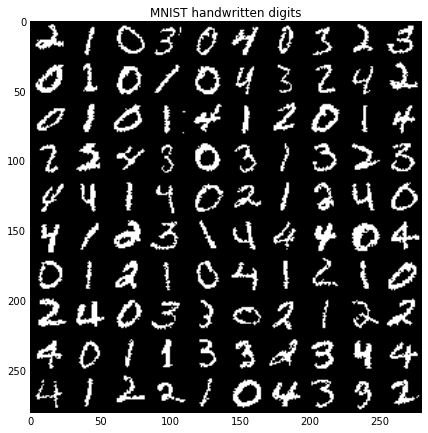

In [3]:
# load and display image and use url to load image
I = io.imread('')
plt.figure() 
plt.axis('off')
plt.imshow(I)
plt.show()

In order to calculate the lower bound, we define following density functions.

In [4]:
#defined a couple of helper functions
c = - 0.5 * math.log(2*math.pi)
def log_bernoulli(x, p, eps=0.0):
    p = T.clip(p, eps, 1.0 - eps)
    return -T.nnet.binary_crossentropy(p, x)

def kl_normal2_stdnormal(mean, log_var):
    return -0.5*(1 + log_var - mean**2 - T.exp(log_var))


### Building the model
When defining the model the latent layer must act as a bottleneck of information, so that we ensure that we find a strong internal representation. We initialize the VAE with 1 hidden layer in the encoder and decoder using relu units as non-linearity.

In [5]:
from lasagne.layers import InputLayer,DenseLayer,get_output, get_all_params
from lasagne.nonlinearities import rectify, sigmoid, leaky_rectify
from samplelayer import SimpleSampleLayer

num_features = x_train.shape[-1]
num_latent_z = 20

#MODEL SPECIFICATION

#ENCODER
l_in_x = InputLayer(shape=(None, num_features))
l_enc = DenseLayer(l_in_x, num_units=128, nonlinearity=leaky_rectify)
#l_enc_2 = DenseLayer(l_enc, num_units=64, nonlinearity=leaky_rectify)
l_muq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=None)     #mu(x)
l_logvarq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x), 
l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq) #sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))
#we split the model into two parts to allow sampling from the decoder model separately
#DECODER
l_in_z = InputLayer(shape=(None, num_latent_z))
l_dec = DenseLayer(l_in_z, num_units=128, nonlinearity=leaky_rectify) 
#l_dec_2 = DenseLayer(l_dec, num_units=64, nonlinearity=leaky_rectify) 
l_mux = DenseLayer(l_dec, num_units=num_features, nonlinearity=sigmoid)  #reconstruction of input using a sigmoid output since mux \in [0,1] 

Following we define the Theano functions for training and evaluation.

In [6]:
sym_x = T.matrix('x')
sym_z = T.matrix('z')

z_train, muq_train, logvarq_train = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=False)
mux_train = get_output(l_mux,{l_in_z:z_train},deterministic=False)

z_eval, muq_eval, logvarq_eval = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=True)
mux_eval = get_output(l_mux,{l_in_z:z_eval},deterministic=True)

mux_sample = get_output(l_mux,{l_in_z:sym_z},deterministic=True)

#define the cost function
def LogLikelihood(mux,x,muq,logvarq):
    log_px_given_z = log_bernoulli(x, mux, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
    KL_qp = kl_normal2_stdnormal(muq, logvarq).sum(axis=1).mean() # * 0 # To ignore the KL term
    LL = log_px_given_z - KL_qp
    return LL, log_px_given_z, KL_qp

LL_train, logpx_train, KL_train = LogLikelihood(mux_train, sym_x, muq_train, logvarq_train)
LL_eval, logpx_eval, KL_eval = LogLikelihood(mux_eval, sym_x, muq_eval, logvarq_eval)

all_params = get_all_params([l_z,l_mux],trainable=True)

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(-LL_train, all_params)

# Set the update function for parameters. The Adam optimizer works really well with VAEs.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=1e-2)

f_train = theano.function(inputs=[sym_x],
                          outputs=[LL_train, logpx_train, KL_train],
                          updates=updates)

f_eval = theano.function(inputs=[sym_x],
                         outputs=[LL_eval, logpx_eval, KL_eval])

f_z = theano.function(inputs=[sym_x],
                         outputs=[z_eval])

f_sample = theano.function(inputs=[sym_z],
                         outputs=[mux_sample])

f_recon = theano.function(inputs=[sym_x],
                         outputs=[mux_eval])



In the training loop we sample each batch and evaluate the error, latent space and reconstructions every epoch.

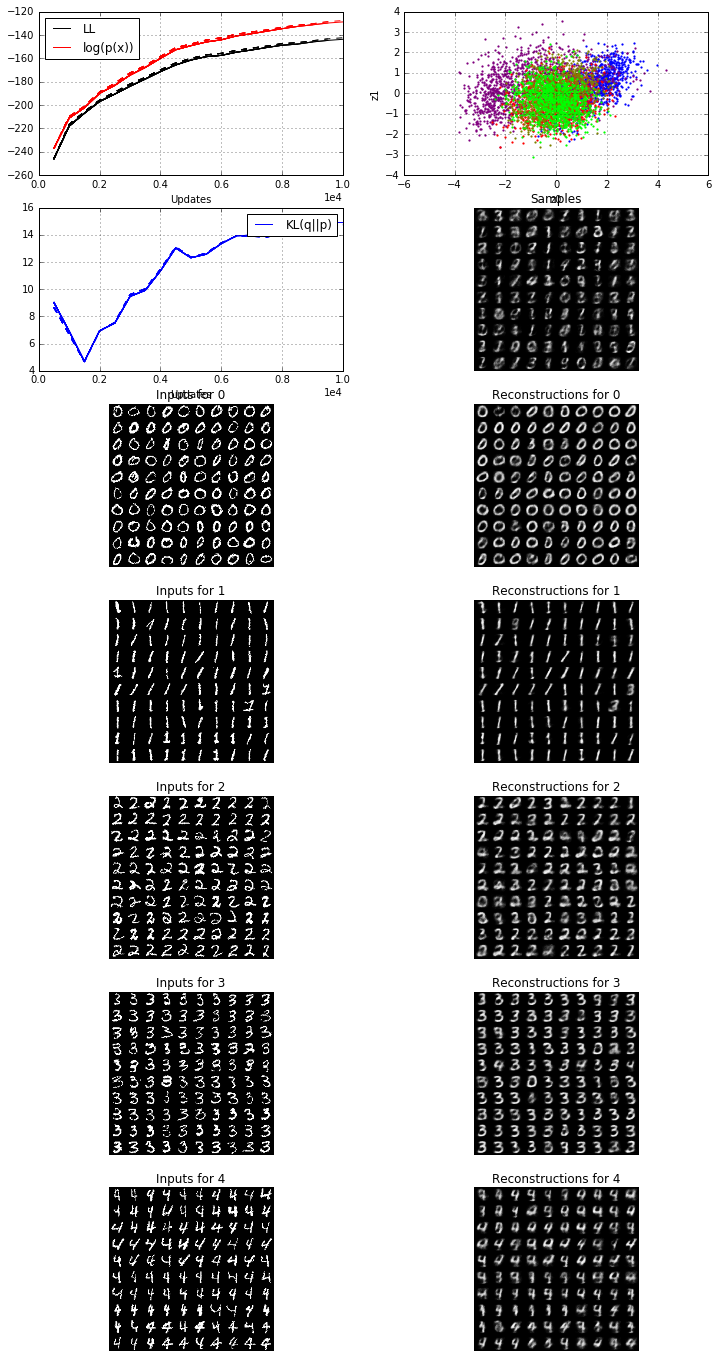

In [7]:
batch_size = 100
samples_to_process = 1e4
val_interval = 5e2
 
LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]
samples_processed = 0
plt.figure(figsize=(12, 24))
valid_samples_processed = []

try:
    while samples_processed < samples_to_process:
        _LL_train, _KL_train, _logpx_train = [],[],[]
        idxs = np.random.choice(range(x_train.shape[0]), size=(batch_size), replace=False)  
        x_batch = x_train[idxs]
        out = f_train(x_batch)
        samples_processed += batch_size
           
        if samples_processed % val_interval == 0:
            valid_samples_processed += [samples_processed]
            out = f_eval(x_train)
            LL_train += [out[0]] 
            logpx_train += [out[1]]
            KL_train += [out[2]]
            
            out = f_eval(x_valid)
            LL_valid += [out[0]]
            logpx_valid += [out[1]]
            KL_valid += [out[2]]
            
            z_eval = f_z(x_valid)[0]
            x_sample = f_sample(np.random.normal(size=(100, num_latent_z)).astype('float32'))[0]
            x_recon = f_recon(x_valid)[0]
            
            plt.subplot(num_classes+2,2,1)
            plt.legend(['LL', 'log(p(x))'], loc=2)
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, LL_train, color="black")
            plt.plot(valid_samples_processed, logpx_train, color="red")
            plt.plot(valid_samples_processed, LL_valid, color="black", linestyle="--")
            plt.plot(valid_samples_processed, logpx_valid, color="red", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,2)
            plt.cla()
            plt.xlabel('z0'), plt.ylabel('z1')
            color = iter(plt.get_cmap('brg')(np.linspace(0, 1.0, num_classes)))
            for i in range(num_classes):
                clr = next(color)
                plt.scatter(z_eval[targets_valid==i, 0], z_eval[targets_valid==i, 1], c=clr, s=5., lw=0, marker='o', )
            plt.grid('on')
            
            plt.savefig("out52.png")
            display(Image(filename="out52.png"))
            clear_output(wait=True)
            
            plt.subplot(num_classes+2,2,3)
            plt.legend(['KL(q||p)'])
            plt.xlabel('Updates')
            plt.plot(valid_samples_processed, KL_train, color="blue")
            plt.plot(valid_samples_processed, KL_valid, color="blue", linestyle="--")
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')
            
            plt.subplot(num_classes+2,2,4)
            plt.cla()
            plt.title('Samples')
            plt.axis('off')
            idx = 0
            canvas = np.zeros((28*10, 10*28))
            for i in range(10):
                for j in range(10):
                    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_sample[idx].reshape((28, 28))
                    idx += 1
            plt.imshow(canvas, cmap='gray')
            
            c=0
            for k in range(5, 5 + num_classes*2, 2):
                plt.subplot(num_classes+2,2,k)
                plt.cla()
                plt.title('Inputs for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((28*10, 10*28))
                for i in range(10):
                    for j in range(10):
                        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_valid[targets_valid==c][idx].reshape((28, 28))
                        idx += 1
                plt.imshow(canvas, cmap='gray')

                plt.subplot(num_classes+2,2,k+1)
                plt.cla()
                plt.title('Reconstructions for %i' % c)
                plt.axis('off')
                idx = 0
                canvas = np.zeros((28*10, 10*28))
                for i in range(10):
                    for j in range(10):
                        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_recon[targets_valid==c][idx].reshape((28, 28))
                        idx += 1
                plt.imshow(canvas, cmap='gray')
                c += 1
        
except KeyboardInterrupt:
    pass
